In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from tqdm import tqdm, trange

In [63]:
n = 5                # number of assets
D = 2                # number of days
N = 20               # number of spins
K = 2                # bits per asset

mu = np.array([[0.12, 0.10, 0.15, 0.09, 0.11],
               [0.15, 0.18, 0.10, 0.11, 0.06]])      # expected return per share
prices = np.array([[10, 12, 8, 15, 7],
                   [11, 10, 7, 15, 8]])             # cost per share
B = 50                                            # budget
lam = 0.3                                        # risk aversion λ
beta = 0.01                                         # transaction cost
alpha = 10.0                                        # penalty coefficient

# Example positive semidefinite covariance matrix
Sigma = np.array([[
        [0.04, 0.01, 0.00, 0.00, 0.01],
        [0.01, 0.05, 0.01, 0.00, 0.00],
        [0.00, 0.01, 0.06, 0.02, 0.00],
        [0.00, 0.00, 0.02, 0.07, 0.01],
        [0.01, 0.00, 0.00, 0.01, 0.03]
    ],[
        [0.05, 0.02, 0.01, 0.00, 0.00],
        [0.02, 0.06, 0.02, 0.01, 0.00],
        [0.01, 0.02, 0.07, 0.03, 0.01],
        [0.00, 0.01, 0.03, 0.08, 0.02],
        [0.00, 0.00, 0.01, 0.02, 0.04]
    ]])

upper_bounds = [[3, 3, 3, 3, 3],
                [3, 3, 3, 3, 3]]   # upper bound search range

In [40]:
# brute force search
classical_upper_bounds = [5] * 10   # upper bound search range

best_x = None
best_value = -1e18
# records = []

# 计算总迭代次数并使用 tqdm 显示进度
total_iters = int(np.prod([ub + 1 for ub in classical_upper_bounds]))

for x in tqdm(itertools.product(*(range(ub + 1) for ub in classical_upper_bounds)), total=total_iters):
    x = np.array(x)
    x1 = x[:n]
    x2 = x[n:]
    cost1 = prices[0] @ x1
    cost2 = prices[1] @ x2
    
    if cost1 <= B and cost2 <= B:
        value1 = mu[0] @ x1 - lam * (x1.T @ Sigma[0] @ x1)
        value2 = mu[1] @ x2 - lam * (x2.T @ Sigma[1] @ x2)
        transaction_cost = beta * (((x2 - x1)*(x2-x1)).sum())
        value = value1 + value2 - transaction_cost
        # records.append([*x, cost1, cost2, value])
        
        if value > best_value:
            best_value = value
            best_x = x.copy()

print("===== Optimal Solution =====")
print("Best x =", best_x)
print("Objective value =", best_value)

100%|██████████| 60466176/60466176 [06:16<00:00, 160493.45it/s]

===== Optimal Solution =====
Best x = [2 0 2 0 2 2 1 1 0 1]
Objective value = 1.0250000000000001


In [95]:
x = [2,0,2,0,2,2,2,0,0,1]
# x = [2,0,2,0,2,2,1,1,0,1]
x = np.array(x)
x1 = x[:n]
x2 = x[n:]
cost1 = prices[0] @ x1
cost2 = prices[1] @ x2

# value1 = mu[0] @ x1 - lam * (x1.T @ Sigma[0] @ x1) - alpha * (cost1 / B - 1)**2
# value2 = mu[1] @ x2 - lam * (x2.T @ Sigma[1] @ x2) - alpha * (cost2 / B - 1)**2
value1 = mu[0] @ x1 - lam * (x1.T @ Sigma[0] @ x1)
value2 = mu[1] @ x2 - lam * (x2.T @ Sigma[1] @ x2)
transaction_cost = beta * (((x2 - x1)*(x2-x1)).sum())
value = value1 + value2 - transaction_cost
print(value1, value2, transaction_cost)
# value = value1 + value2
print("Objective value for x =", x, "is", value)
print("Cost day 1:", cost1, "Cost day 2:", cost2)

0.5800000000000001 0.528 0.09
Objective value for x = [2 0 2 0 2 2 2 0 0 1] is 1.018
Cost day 1: 50 Cost day 2: 50


In [64]:
def IsingCoeffsPart(n, n_per, sigma, mu, prices, B, lam, alpha):
    N = n * n_per
    price_rate = prices / B
    C = np.zeros((n,N))     # conversion matrix
    for i in range(n):
        for p in range(n_per):
            C[i, i*n_per + p] = 2**p

    # J_x = lambda * C^T * sigma * C + alpha C^T * p' * p'^T * C
    J = lam * C.T @ sigma @ C + alpha * np.outer(C.T @ price_rate, C.T @ price_rate)
    # h_x = - (C^T * mu + 2 alpha B C^T * p')
    h = - (C.T @ mu + 2 * alpha * (C.T @ price_rate))
    Const = alpha

    return J, h, Const

def IsingCoeffsTransaction(n, n_per, sigma, mu, prices, B, lam, beta, alpha, D):
    N = n * n_per * D
    C = np.zeros((n,n*n_per))     # conversion matrix
    for i in range(n):
        for p in range(n_per):
            C[i, i*n_per + p] = 2**p
    J_x = np.zeros((N,N))
    h_x = np.zeros(N)
    Const_x = 0.0

    for d in range(D):
        J_d, h_d, Const_d = IsingCoeffsPart(n, n_per, sigma[d], mu[d], prices[d], B, lam, alpha)
        J_x[d*n*n_per:(d+1)*n*n_per, d*n*n_per:(d+1)*n*n_per] = J_d
        h_x[d*n*n_per:(d+1)*n*n_per] = h_d
        Const_x += Const_d
    
    # Transaction cost term
    trans = beta * C.T @ C
    for d in range(D-1):
        J_x[d*n*n_per:(d+1)*n*n_per, d*n*n_per:(d+1)*n*n_per] += trans
        J_x[(d+1)*n*n_per:(d+2)*n*n_per, (d+1)*n*n_per:(d+2)*n*n_per] += trans
        J_x[d*n*n_per:(d+1)*n*n_per, (d+1)*n*n_per:(d+2)*n*n_per] -= trans
        J_x[(d+1)*n*n_per:(d+2)*n*n_per, d*n*n_per:(d+1)*n*n_per] -= trans

    # x -> (1+s)/2
    J = 0.25 * J_x
    h = 0.5 * h_x + 0.25 * np.sum(J_x, axis=1) + 0.25 * np.sum(J_x, axis=0)
    Const = Const_x + 0.25 * np.sum(J_x) + 0.5 * np.sum(h_x)

    # symmetrize J
    # add diagonal terms of J to Const
    Const += np.sum(np.diag(J))
    J = J + J.T
    # make J upper triangular
    for i in range(N):
        for j in range(N):
            if i >= j:
                J[i,j] = 0.0
    return h, J, Const

In [65]:
h, J, Const = IsingCoeffsTransaction(n, K, Sigma, mu, prices, B, lam, beta, alpha, D)
# print("h =", h)
# print("J =", J)
# print("Const =", Const)

In [66]:
# enumerate all possible states to verify
max_energy = -np.inf
min_energy = np.inf
min_energy_state = None
for state in trange(2**N):
    z = np.array([1 if (state >> i) & 1 == 0 else -1 for i in range(N)])
    energy = z @ J @ z + h @ z + Const
    max_energy = max(max_energy, energy) 
    if energy < min_energy:
        min_energy = energy
        min_energy_state = z

print("\nMax energy from enumeration:", max_energy)
print("Min energy from enumeration:", min_energy)
print("Min energy state from enumeration:", min_energy_state)

100%|██████████| 1048576/1048576 [00:11<00:00, 92163.23it/s] 


Max energy from enumeration: 86.32700000000001
Min energy from enumeration: -1.0179999999999936
Min energy state from enumeration: [-1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1 -1  1 -1]


In [71]:
def U_H(J, h, t):
    qc = QuantumCircuit(N)
    for i in range(N):
        if h[i] != 0:
            qc.rz(-2 * h[i] * t, i)
    for i in range(N):
        for j in range(i + 1, N):
            if J[i, j] != 0:
                qc.cx(i, j)
                qc.rz(-2 * J[i, j] * t, j)
                qc.cx(i, j)
    return qc

def U_x(B, t):
    qc = QuantumCircuit(N)
    for i in range(N):
        qc.rx(2 * B * t, i)
    return qc

def trotter_annealing(T=10, M=100, B=1.0):
    """Simulate quantum annealing using first-order Trotter decomposition."""
    dt = T / M
    qc = QuantumCircuit(N)
    qc.h(range(N))  # Initialize in |+> state
    for i in range(M):
        s = i / M
        qc.append(U_x(B * (1 - s), dt), range(N))
        qc.append(U_H(J, h, dt * s), range(N))
    return qc


def compute_energy(bitstring, J, h, C):
    """Compute Ising energy given spin configuration (+1/-1)."""
    #print(bitstring)
    S = np.array([1 if b == '0' else -1 for b in bitstring[::-1]])
    return S @ J @ S + np.dot(h, S) + C

In [72]:
qc = trotter_annealing(T=10, M=1000, B=1) # TODO: how to choose parameters
qc.measure_all()
sim = AerSimulator()
result = sim.run(transpile(qc, sim), shots=1000).result()
counts = result.get_counts()

# Compute energies for each measurement
energies = []
min_energy = np.inf
ground_state = None
for bitstring, count in counts.items():
    E = compute_energy(bitstring, J, h, Const)
    energies += [E] * count
    if E < min_energy:
        min_energy = E
        ground_state = np.array([1 if b == '0' else -1 for b in bitstring[::-1]])

In [102]:
# calculate asset number and slack variable
min_energy = min(energies)
print("min energy:", min_energy)
print("ground state:", ground_state)

asset_counts = []
for i in range(n*D):
    count = 0
    for p in range(K):
        idx = i*K + p
        if ground_state[idx] == 1:
            count += 2**p
    asset_counts.append(count)

asset_counts = np.array(asset_counts).reshape(D, n)
print("Asset counts:", asset_counts)

# Total cost , Expected return, Variance
total_cost = 0.0
expected_return = 0.0
variance = 0.0
for i in range(D):
    total_cost += np.sum(prices[i] * asset_counts[i])
    expected_return += np.sum(mu[i] * asset_counts[i])
    variance += lam * (asset_counts[i].T @ Sigma[i] @ asset_counts[i])
for i in range(D-1):
    expected_return -= beta * np.sum((asset_counts[i] - asset_counts[i+1])**2)
print("Total cost:", total_cost)
print("Expected return:", expected_return)
print("Variance:", variance)

min energy: -1.0179999999999936
ground state: [-1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1 -1  1 -1]
Asset counts: [[2 0 2 0 2]
 [2 2 0 0 1]]
Total cost: 100.0
Expected return: 1.39
Variance: 0.372


In [103]:
energies_sort = np.sort(np.array(energies))
print(energies_sort[:10])

[-1.018 -1.017 -0.971 -0.964 -0.964 -0.952 -0.945 -0.941 -0.941 -0.936]


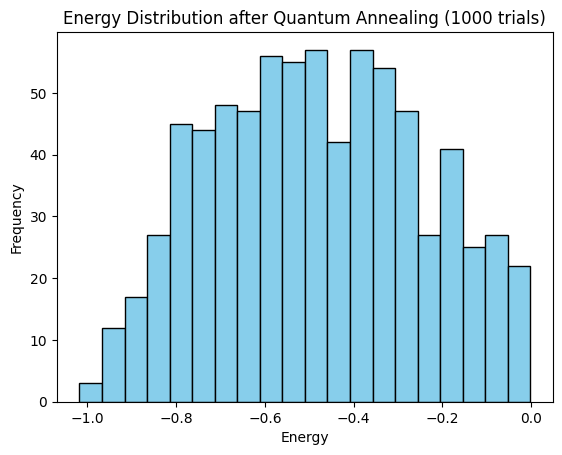

In [101]:
# Plot histogram
energies = np.array(energies)
# valid energy <= 0
valid_energies = energies[(~np.isinf(energies)) & (energies <= 0)]
plt.hist(valid_energies, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Energy Distribution after Quantum Annealing (1000 trials)')
plt.show()